# Importing Modules

In [1]:
import torch 
import torch.nn as nn
import torch.functional as F

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim 
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import torchvision.utils as imutils

import pandas as pd
import numpy as np
import os
from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Using CUDA or CPU based on availibility
print("Device: {}".format(device))

print("PyTorch Version: {}".format(torch.__version__)) # PyTorch Version

Device: cuda:1
PyTorch Version: 1.1.0


# Dataset

In [2]:
BASE_DIR = '.'
print(os.path.exists(BASE_DIR))

True


## Visualization Utility Functions

In [3]:
# Function to show face image along with 15 Facial Keypoints
def show_landmarks(image,landmarks,actual_landmarks=None,figsize=(5,5)):
    #landmarks-> actual landmarks should be passed when only one true landmark is to be shown otherwise predicted landmark.
    #actual_landmarks -> when actual and predicted landmarks need to be compared
    '''
    This function assumes that the image is a grayscale and 2D(no channel) & is passed as pytorch tensor.
    It also assumes that the image is normalized with mean = 0.5 and standard deviation=0.5
    
    '''
  plt.figure(figsize=figsize)
  img = image.numpy().squeeze()*0.5+0.5
  plt.imshow(img,cmap='gray')
  ind_even = [i for i in range(0,30,2)]
  ind_odd = [i for i in range(1,30,2)]
  plt.scatter(landmarks[ind_even].numpy(),landmarks[ind_odd].numpy(),c='r')
  if actual_landmarks is not None:
    plt.scatter(actual_landmarks[ind_even].numpy(),actual_landmarks[ind_odd].numpy(),c='y')
    plt.legend(['Predicted','Actual'])
  plt.axis('off')
  plt.show()

## Custom Dataset Class

There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

source: https://www.kaggle.com/c/facial-keypoints-detection/data


1. **training.csv**: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
2. **test.csv**: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels

In [4]:
# Custom Dataset Class for Facial Keypoints Dataset
class FaceDataset(Dataset):
  def __init__(self, root,csv_file,dimension,transform=None,train=False,train_size=0.8,test_size=0.2):
    self.data = pd.read_csv(os.path.join(root, csv_file)) # Reads the training.csv file as pandas Dataframe
    self.data = self.data.dropna() # It drops all the rows having NULL values as data cleaning
    self.X = self.data.drop([self.data.columns.tolist()[-1]],axis=1) # List of Keypoints locations
    self.Y = self.data[self.data.columns.tolist()[-1]] # Pixel values of images
    self.dimension = dimension
    self.is_train = train
    
    # It divides the dataset based on the train_size passed
    if train:
      self.X,_,self.Y,_ = train_test_split(self.X,self.Y,train_size = train_size, random_state=40) 
    else:
      _,self.X,_,self.Y = train_test_split(self.X,self.Y,test_size = test_size, random_state=40)
    
    self.length = len(self.X)
    self.transform = transform

  def __len__(self):
    return self.length
  
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    '''
    30 coordinates (15  x-y pairs) are extracted from idx-th row from the train/test split data (X).
    It is stored as 1D Tensor and 30D Vector.
    The order of coordinates are:
    
    left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, left_eye_inner_corner_x, 
    left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, 
    right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, 
    left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, 
    right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, nose_tip_x, nose_tip_y, 
    mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, 
    mouth_center_top_lip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y
    '''
    keypoints = torch.from_numpy(self.X.iloc[idx,:].values.astype('float64'))
    
    '''
    Image pixels from idx-th row of Y is converted to float and the reshaped to given dimension,
    which in this case is 96x96.
    '''
    img = list(map(float,self.Y.iloc[idx].strip().split()))
    img = np.array(img)
    img = np.reshape(img,self.dimension)
    '''
    After reshaping, it is converted to PIL Image so that torchvision can work upon it.
    Image is the then transformed using the transforms provided as parameter is constructor
    '''
    img = Image.fromarray(img)

    if self.transform:
      img = self.transform(img)
    
    return img, keypoints

## Visualizing Dataset

In [5]:
# Transforms to apply to images
transform = transforms.Compose([
  transforms.ToTensor(), # converts the PIL Image to PyTorch Tensor
  transforms.Normalize(mean=[0.5],std=[0.5]) # Image is normalized with mean=0.5 and std=0.5
])

In [6]:
dataset = FaceDataset(BASE_DIR,'training.csv',dimension=(96,96),transform = transform, train=True) # Training Data
test_dataset = FaceDataset(BASE_DIR,'training.csv',dimension=(96,96),transform = transform, train=False) # Test/Validation Data

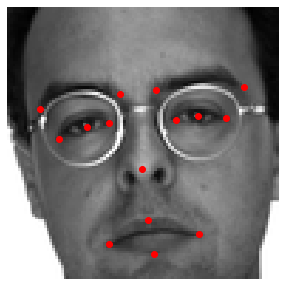

In [7]:
# Random Image from Train Data
ind = np.random.randint(0,len(dataset))
show_landmarks(dataset[ind][0],dataset[ind][1],actual_landmarks=None, figsize=(5,5))

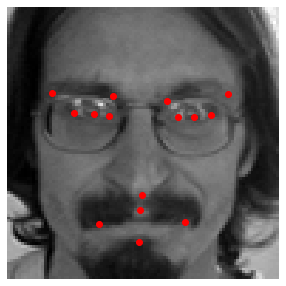

In [8]:
# Random Image from Test Data
ind = np.random.randint(0,len(test_dataset))
show_landmarks(test_dataset[ind][0],test_dataset[ind][1],actual_landmarks=None, figsize=(5,5))

# Model

In [9]:
# A basic CNN-based Regressor model for Facial Keypoints Prediction.
'''
1. Feature Extractor uses CNN architecture
2. Features Extrated are then passed through Fully Connected Neural Network Acting as Regressor.
3. Input Size = (1,96,96) | Output Size: (30) [15 (x,y) pairs]
'''

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=1, padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512)
    )

    self.regressor = nn.Sequential(
        nn.Linear(512*6*6,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.4),
        nn.Linear(256,30)
    ) 
    
  def forward(self, input_):
    input_ = self.features(input_)
    input_ = input_.view(input_.size(0),-1)
    return self.regressor(input_)

In [10]:
model = Net()
summary(model,(1,96,96),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             832
              ReLU-2           [-1, 32, 96, 96]               0
       BatchNorm2d-3           [-1, 32, 96, 96]              64
         MaxPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,496
              ReLU-6           [-1, 64, 48, 48]               0
       BatchNorm2d-7           [-1, 64, 48, 48]             128
         MaxPool2d-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
             ReLU-10          [-1, 128, 24, 24]               0
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         295,168
             ReLU-14          [-1, 256,

# Training

In [0]:
trainLoader = DataLoader(dataset, batch_size = 64, shuffle=True, num_workers=20) # Batch generator for training Data
testLoader = DataLoader(test_dataset,batch_size=64,shuffle=True, num_workers=20) # Batch Generator for test data

In [0]:
model = Net() # Instantiating the model
loss_fn = nn.MSELoss() # Choosing the Loss Function as Mean Squared Error since the task is regression
model = model.to(device) # Moving the model to device ('cuda' or 'cpu')
optimizer = optim.Adam(model.parameters(),lr=0.0001) # Choosing Adam optimizer with learning_rate-1e-4. Assigning model's
                                                    # weight to it.

In [309]:
num_epochs = 60
# metrics to store per epoch Loss for Training and Testing Data
metrics = {
    "loss":{'train':[],'test':[]},
}

for epoch in range(1,num_epochs+1):
    # metrics_temp used to calculate metrics for every individual epochs
  metrics_temp = {
    "loss":{'train':0,'test':0},
    "count":{'train':0,'test':0},
  }
  lr = 0.0001 * (0.5 ** (epoch // 15))
  for param_group in optimizer.param_groups:
      param_group['lr'] = lr
    
  # Training the data

  # Putting the model in train mode so that DropOut works.  
  model.train()
  for i, data in tqdm(enumerate(trainLoader,0),total=len(trainLoader),unit='Step'):
    X,Y = data # Splitting data into input,target
    X,Y = X.to(device),Y.to(device) # Moving input and target to GPU
    output = model(X) # passing the input to model and Output is calculated for every image in batch
    loss = loss_fn(output,Y.float()) # loss is calcuated between predicted(output) and target(Y)
    model.zero_grad() # Setting the gradient to zero for the model
    optimizer.zero_grad()# Setting the gradient to zero for optimizer
    loss.backward()# Calculating gradient for every tensor which is used to calculate 'loss'
    optimizer.step()# Weights(parameters) are updated which are related to 'optimizer' i.e., model.classifier
    del X,Y,loss# X,Y and loss are deleted for saving memory

  # Evaluating the model for this epoch

  # Putting the model in evaluation mode which turns of Dropout and parameters are fixed for every model.
  model.eval()
  with torch.no_grad():
    #Train Data
    for i, data in enumerate(trainLoader,0):
      X,Y = data
      X,Y = X.to(device),Y.to(device)
      # Y = Y.unsqueeze(1)
      output = model(X)
      loss = loss_fn(output,Y.float())
      metrics_temp['loss']['train']+=loss.item()
      metrics_temp['count']['train']+=len(Y)
      del X,Y,loss

    #Test Data
    for i, data in enumerate(testLoader,0):
      X,Y = data
      X,Y = X.to(device),Y.to(device)
      # Y = Y.unsqueeze(1)
      output = model(X)
      loss = loss_fn(output,Y.float())
      metrics_temp['loss']['test']+=loss.item()
      metrics_temp['count']['test']+=len(Y)
      del X,Y,loss

  metrics['loss']['train'].append(metrics_temp['loss']['train']/metrics_temp['count']['train'])

  metrics['loss']['test'].append(metrics_temp['loss']['test']/metrics_temp['count']['test'])

  print("Epoch: {}/{} loss:{} |  test_loss:{} | ".format(
      epoch,num_epochs,metrics['loss']['train'][-1],metrics['loss']['test'][-1]
  ))

Epoch: 1/60 loss:9.178976361996659 |  test_loss:9.492396559670707 | 


Epoch: 2/60 loss:0.4324628070136097 |  test_loss:0.44505333231988353 | 


Epoch: 3/60 loss:0.32006920832339847 |  test_loss:0.3335854984889521 | 


Epoch: 4/60 loss:0.27544884648278495 |  test_loss:0.29244638380603255 | 


Epoch: 5/60 loss:0.21981619006005404 |  test_loss:0.2326126366018135 | 


Epoch: 6/60 loss:0.18280006847648977 |  test_loss:0.19173236428020157 | 


Epoch: 7/60 loss:0.1592698331191161 |  test_loss:0.173341659741981 | 


Epoch: 8/60 loss:0.16458143196373343 |  test_loss:0.17698099234393824 | 


Epoch: 9/60 loss:0.13725689248503925 |  test_loss:0.1459167248734804 | 


Epoch: 10/60 loss:0.1261835563405652 |  test_loss:0.13412548782669495 | 


Epoch: 11/60 loss:0.12688498268617648 |  test_loss:0.13991374390147557 | 


Epoch: 12/60 loss:0.13223039129070033 |  test_loss:0.14617502800772122 | 


Epoch: 13/60 loss:0.11773726204845393 |  test_loss:0.13107122327679785 | 


Epoch: 14/60 loss:0.13252315927888744 |  test_loss:0.15152118919051696 | 


Epoch: 15/60 loss:0.10664421737751115 |  test_loss:0.12131488100390568 | 


Epoch: 16/60 loss:0.11373654425701249 |  test_loss:0.1288446800731053 | 


Epoch: 17/60 loss:0.09749251436964373 |  test_loss:0.10831091225704301 | 


Epoch: 18/60 loss:0.1273413523335323 |  test_loss:0.1459943602018267 | 


Epoch: 19/60 loss:0.09941948685690621 |  test_loss:0.11326565586517905 | 


Epoch: 20/60 loss:0.10472129159998671 |  test_loss:0.11956049794348601 | 


Epoch: 21/60 loss:0.09457473888575474 |  test_loss:0.1093514478095224 | 


Epoch: 22/60 loss:0.08336260900876233 |  test_loss:0.09686643275145058 | 


Epoch: 23/60 loss:0.13842338880645894 |  test_loss:0.16077420644671003 | 


Epoch: 24/60 loss:0.09122404706812351 |  test_loss:0.10473863432340533 | 


Epoch: 25/60 loss:0.08657512904327606 |  test_loss:0.09953863598475947 | 


Epoch: 26/60 loss:0.07249825078750326 |  test_loss:0.08341817655295969 | 


Epoch: 27/60 loss:0.10315813723011552 |  test_loss:0.11920267064994741 | 


Epoch: 28/60 loss:0.07211621244934117 |  test_loss:0.08137707008379642 | 


Epoch: 29/60 loss:0.07775111162216863 |  test_loss:0.09138418915115784 | 


Epoch: 30/60 loss:0.07564678175427089 |  test_loss:0.09076769775319322 | 


Epoch: 31/60 loss:0.0718095514261834 |  test_loss:0.0863137289742443 | 


Epoch: 32/60 loss:0.07386373986150617 |  test_loss:0.08902420841644858 | 


Epoch: 33/60 loss:0.0659900831284924 |  test_loss:0.07944696528889308 | 


Epoch: 34/60 loss:0.07387493174766825 |  test_loss:0.08692191081626394 | 


Epoch: 35/60 loss:0.06467206748289482 |  test_loss:0.07627461725306288 | 


Epoch: 36/60 loss:0.07183943117890403 |  test_loss:0.08639120665666099 | 


Epoch: 37/60 loss:0.06877201182819973 |  test_loss:0.08267872968566752 | 


Epoch: 38/60 loss:0.07275398242696424 |  test_loss:0.08768890505639192 | 


Epoch: 39/60 loss:0.05875949171658988 |  test_loss:0.06952044896990339 | 


Epoch: 40/60 loss:0.07021838134137269 |  test_loss:0.0849749128395152 | 


Epoch: 41/60 loss:0.05977714855537236 |  test_loss:0.07444833205125043 | 


Epoch: 42/60 loss:0.05800223726535512 |  test_loss:0.06915437395327559 | 


Epoch: 43/60 loss:0.06251066742099334 |  test_loss:0.07589289963802445 | 


Epoch: 44/60 loss:0.06687680931291848 |  test_loss:0.08264730188334099 | 


Epoch: 45/60 loss:0.07494834538932159 |  test_loss:0.09053174691779592 | 


Epoch: 46/60 loss:0.05676166782869357 |  test_loss:0.0700066373727032 | 


Epoch: 47/60 loss:0.06115484376934087 |  test_loss:0.07557646414943944 | 


Epoch: 48/60 loss:0.06025702332224801 |  test_loss:0.07541471552625995 | 


Epoch: 49/60 loss:0.05432249522097757 |  test_loss:0.06762144721557047 | 


Epoch: 50/60 loss:0.061838826425721714 |  test_loss:0.07619609955315278 | 


Epoch: 51/60 loss:0.05667825182464635 |  test_loss:0.07056189196132054 | 


Epoch: 52/60 loss:0.06061270805162804 |  test_loss:0.07812094966941904 | 


Epoch: 53/60 loss:0.05620782996449515 |  test_loss:0.0726431290680003 | 


Epoch: 54/60 loss:0.05845443027041783 |  test_loss:0.07516884191013942 | 


Epoch: 55/60 loss:0.055001554505847323 |  test_loss:0.0692162329905501 | 


Epoch: 56/60 loss:0.05410907675172681 |  test_loss:0.06853291865821197 | 


Epoch: 57/60 loss:0.0563186065894421 |  test_loss:0.07091281402890927 | 


Epoch: 58/60 loss:0.05480545606011542 |  test_loss:0.0699612587411827 | 


Epoch: 59/60 loss:0.05154603441184926 |  test_loss:0.06405257733068734 | 


Epoch: 60/60 loss:0.051159172275356046 |  test_loss:0.064430237373459 | 


In [0]:
torch.save(model.state_dict(),os.path.join(BASE_DIR,'weights.pth')) # Saving the weights of the trained model

# Metrics Plot

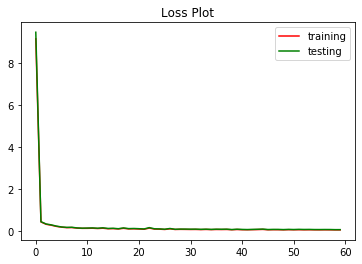

In [311]:
# Loss Plot
plt.plot(metrics['loss']['train'],'r')
plt.plot(metrics['loss']['test'],'g')
plt.legend(['training','testing'])
plt.title('Loss Plot')
plt.show()

# Inference

In [12]:
model.load_state_dict(torch.load(os.path.join(BASE_DIR,'weights.pth'))) # Loading the saved weights of the model

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

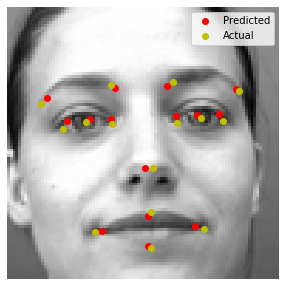

In [15]:
# Testing on different test images
with torch.no_grad():
  ind = np.random.randint(0,len(test_dataset))
  img = test_dataset[ind][0].unsqueeze(0)
  model.cpu()
  model.eval()
  pred_landmarks = model(img)
  # print(pred_landmarks)
  show_landmarks(img,pred_landmarks.squeeze(),test_dataset[ind][1],figsize=(5,5))

# Kaggle Submission

In [16]:
data = pd.read_csv(os.path.join(BASE_DIR,'training.csv'))

In [17]:
columns = data.columns.tolist()[:-1]

In [33]:
for column in columns:
    print(column, end=', ')

left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, nose_tip_x, nose_tip_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y, 

In [18]:
columns_int = {}
for i,column in enumerate(columns):
  columns_int[column]=i

In [19]:
class FaceDataset_t(Dataset):
  def __init__(self, root,csv_file,dimension,transform=None):
    self.data = pd.read_csv(os.path.join(root, csv_file))
    self.data = self.data.dropna()
    self.length = len(self.data)
    self.transform = transform
    self.dimension = dimension
  def __len__(self):
    return self.length
  
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    imageid = self.data.iloc[idx,0]
    img = list(map(float,self.data.iloc[idx,1].strip().split()))
    img = np.array(img)
    img = np.reshape(img,self.dimension)
    img = Image.fromarray(img)

    if self.transform:
      img = self.transform(img)
    
    return img, imageid

In [20]:
testDataset = FaceDataset_t(BASE_DIR,'test.csv',dimension=(96,96),transform=transform)

In [21]:
model.load_state_dict(torch.load(os.path.join(BASE_DIR,'weights.pth')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

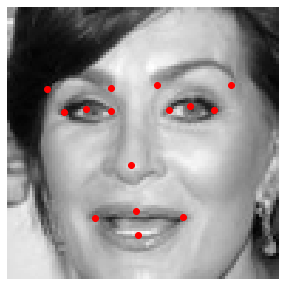

In [29]:
# Testing on images of test.csv
with torch.no_grad():
  ind = np.random.randint(0,len(testDataset))
  img = testDataset[ind][0].unsqueeze(0)
  model.cpu()
  model.eval()
  pred_landmarks = model(img)
  # print(pred_landmarks)
  show_landmarks(img,pred_landmarks.squeeze(),None,figsize=(5,5))

In [30]:
with torch.no_grad():
  model.eval()
  model.cpu()
  z = 1
  predictions = []
  print("Predicting: ")
  for i,data in tqdm(enumerate(testDataset,1),total=len(testDataset)):
    img = data[0].unsqueeze(0)
    pred_landmarks = model(img)
    pred_landmarks = pred_landmarks.squeeze().numpy().tolist()
    predictions.append(pred_landmarks)

dd = pd.read_csv(os.path.join(BASE_DIR,'IdLookupTable.csv'))
rowId = []
Location = []
print('Making CSV File: ')
for row in tqdm(dd.iterrows(),total=len(dd)):
  r = row[1]
  rowId.append(r['RowId'])
  Location.append(predictions[r['ImageId']-1][columns_int[r['FeatureName']]])

output = pd.DataFrame({'RowId':rowId,'Location':Location},index=None)
file_Name = 'submission.csv'
output.to_csv(os.path.join(BASE_DIR,file_Name),index=False)
print("Submission File save as {}".format(file_Name))

Predicting: 



Making CSV File: 



Submission File save as submission.csv
